# CSE 151B Autonomous Vehicle Kaggle Competition EDA

Run the provided Jupyter notebook for loading the data. Provide exploratory analysis on thedata and report your findings with texts and figures. Your report should answer the followingquestions at a minimum:

- what is the train/test data size, how many dimensions of inputs/outputs
- what is the distribution of input positions for all agents (hint: use histogram)
- what is the distribution of output positions for all agents (hint: use histogram)
- what is the distribution of velocity (magnitude) of all agents and the target agent

If you include more exploratory analysis beyond the above questions that provides in- sightsinto the data, you will receive bonus points

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pandas as pd
import random
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
from glob import glob
import matplotlib.pyplot as plt
import random
import multiprocessing
from tqdm import tqdm
import seaborn as sns
from IPython.display import display

In [6]:
sys.path.append(os.path.dirname(os.getcwd()))
# from run_model import my_collate, my_collate2, ArgoverseDataset, sample_files, dataloader_to_csv
from src.ArgoverseDataset import ArgoverseDataset
from src.utility import collate_train, collate_val, sample_files, dataloader_to_csv

ModuleNotFoundError: No module named 'run_model'

## Load DataSet

Use the provided `ArgoverseDataset` PyTorch DataSet class to load data into a dataset, then use the other provided `my_collate` method as a collate function in the PyTorch DataLoader class to be used.

In [ ]:
train_path = "/home/apfriend/ucsd/CURRENT/cse151b/kaggle/data/new_train/new_train"
val_path="/home/apfriend/ucsd/CURRENT/cse151b/kaggle/data/new_val_in/new_val_in"

In [4]:
val_dataset=ArgoverseDataset(data_path=val_path)
train_dataset=ArgoverseDataset(data_path=train_path)

batchsize = 4

#use same number of workers as CPU cores (4)
nworkers=multiprocessing.cpu_count()

#need different collate function for validation set since it has no `p_out` or `v_out`

val_loader = DataLoader(
    val_dataset,
    batch_size=batchsize, 
    shuffle = False, 
    collate_fn=my_collate2, 
    num_workers=nworkers
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batchsize, 
    shuffle = True, 
    collate_fn=my_collate, 
    num_workers=nworkers
)

NameError: name 'val_path' is not defined

## Train and Test Set Dimensionality

The dimensions of the training data are $2 \times \mathrm{batch\ size} \times 60 \times 19 \times 4$

>There are the input and output data (2)

>There are 60 cars for 1.9 seconds at 10Hz (19)

>For each input/output (for each car) there are positions, velocities in (x,y) coordinates (last 4)

In [5]:
print("Training set size: %s"%(int(len(train_loader))*batchsize))

for batch in train_loader:
    train_batch=batch#.detach().numpy()
    break;
    
dimensions=(
    len(train_batch), 
    len(train_batch[0]),
    len(train_batch[0][0]),
    len(train_batch[0][0][0]), 
    len(train_batch[0][0][0][0])
)
    
print(f"Training set dimensions: {dimensions}")

Training set size: 205944
Training set dimensions: (2, 4, 60, 19, 4)


The dimensions of the validation data are the same as training data except it does not have an output. $\mathrm{batch\ size} \times 60 \times 19 \times 4$

>There are 60 cars for 1.9 seconds at 10Hz (19)

>For each input and output (each car) there are positions, velocities in (x,y) coordinates (last 4)

In [6]:
print("Validation set size: %s"%(int(len(val_loader))*batchsize))


for batch in val_loader:
    val_batch=batch#.detach().numpy()
    break;
    
dimensions=(
    len(val_batch), #batch size
    len(val_batch[0]), #number of vehicles
    len(val_batch[0][0]), #each time interval,
    len(val_batch[0][0][0]) #positions
)
    
print(f"Training set dimensions: {dimensions}")

Validation set size: 3200
Training set dimensions: (4, 60, 19, 4)


### Create a sample set of train values to compute statistics like histogram

In [7]:
train_path

'/home/apfriend/ucsd/CURRENT/cse151b/kaggle/data/new_train/new_train'

In [13]:
sample_path='/home/apfriend/ucsd/CURRENT/cse151b/kaggle/data/sample'
train_sample_path=os.path.join(sample_path, "train_sample")
# sample 2000 files of the 205,942 .pkl files
sample_size=2000

#saving sample files to new directory
sample_files(
    src=train_path, 
    dst=train_sample_path, 
    sample_size=sample_size
)

#create new DataLoader object from sampled files
sample_dataset=ArgoverseDataset(data_path=train_sample_path)

#give full permissions to sample data
!chmod -R +777 $sample_path


sample_out_fn='sample_out.csv'





In [14]:
batchsize = 200

#use same number of workers as CPU cores (4)
nworkers=multiprocessing.cpu_count()

sample_loader = DataLoader(
    sample_dataset,
    batch_size=batchsize, 
    shuffle = True, 
    collate_fn=my_collate, 
    num_workers=nworkers
)

dataloader_to_csv(
    data_loader=sample_loader,
    dst=sample_path,
    in_fn=sample_in_fn,
    out_fn=sample_out_fn
)

100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


### Histogram of Sample Data

In [19]:
sample_in_fp=os.path.join(sample_path, "sample_in.csv")
sample_out_fp=os.path.join(sample_path, "sample_out.csv")

sample_in_df=pd.read_csv(sample_in_fp)
sample_out_df=pd.read_csv(sample_out_fp)

display(sample_in_df.head())
sample_out_df.head()

,x_pos,y_pos,x_vel,y_vel
0,497.181702,3995.872314,0.001405,-0.003492
1,497.181915,3995.871826,0.002322,-0.005172
2,497.182190,3995.871826,0.002748,-0.000411
3,497.182098,3995.871338,-0.001016,-0.004760
4,497.182343,3995.870850,0.002407,-0.004704


,x_pos,y_pos,x_vel,y_vel
0,497.184174,3995.864746,0.003756,0.000095
1,497.184113,3995.863770,-0.000717,-0.010065
2,497.184326,3995.862549,0.001965,-0.011957
3,497.184631,3995.862549,0.003233,0.000564
4,497.184570,3995.861816,-0.000612,-0.007035


In [22]:
sample_in_df.describe()

,x_pos,y_pos,x_vel,y_vel
count,2.280000e+06,2.280000e+06,2.280000e+06,2.280000e+06
mean,2.108387e+02,3.245734e+02,3.604328e-02,-1.889331e-02
std,7.032012e+02,8.485306e+02,1.749104e+00,2.185653e+00
min,0.000000e+00,0.000000e+00,-1.144689e+02,-1.688118e+02
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,4.735943e+03,4.092156e+03,7.909621e+01,1.461265e+02


In [23]:
sample_out_df.describe()

,x_pos,y_pos,x_vel,y_vel
count,3.600000e+06,3.600000e+06,3.600000e+06,3.600000e+06
mean,2.109253e+02,3.245277e+02,3.481067e-02,-1.777745e-02
std,7.034579e+02,8.483126e+02,1.797118e+00,2.223628e+00
min,0.000000e+00,0.000000e+00,-1.008539e+02,-1.215008e+02
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,4.736574e+03,4.092117e+03,8.774132e+01,1.484342e+02


In [51]:
%matplotlib widget

#set font of all images
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

save_path=os.path.join(fig_path, "sample-in-position-hist.pdf")

num_bins=30

fig, axs=plt.subplots(1,2, figsize=(16,8))
fig.suptitle("Distribution of Input Positions")
fig.patch.set_facecolor("white")

axs[0].hist(
    x=sample_in_df.x_pos,
    bins=num_bins    
)
axs[1].hist(
    x=sample_in_df.y_pos,
    bins=num_bins    
)

axs[0].set_title("X-Coordinate Input Positions")
axs[1].set_title("Y-Coordinate Input Positions")
fig.savefig(save_path)
fig.show();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [52]:
save_path=os.path.join(fig_path, "sample-out-position-hist.pdf")

num_bins=30

fig, axs=plt.subplots(1,2, figsize=(16,8))
fig.suptitle("Distribution of Output Positions")
fig.patch.set_facecolor("white")

axs[0].hist(
    x=sample_out_df.x_pos,
    bins=num_bins    
)
axs[1].hist(
    x=sample_out_df.y_pos,
    bins=num_bins    
)

axs[0].set_title("X-Coordinate Output Positions")
axs[1].set_title("Y-Coordinate Output Positions")
fig.savefig(save_path)
fig.show();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [53]:
save_path=os.path.join(fig_path, "sample-in-velocity-hist.pdf")

num_bins=30

fig, axs=plt.subplots(1,2, figsize=(16,8))
fig.suptitle("Distribution of Input Velocities")
fig.patch.set_facecolor("white")

axs[0].hist(
    x=sample_in_df.x_vel,
    bins=num_bins    
)
axs[1].hist(
    x=sample_in_df.y_vel,
    bins=num_bins    
)

axs[0].set_title("X-Coordinate Input Velocities")
axs[1].set_title("Y-Coordinate Input Velocities")
fig.savefig(save_path)
fig.show();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [54]:
save_path=os.path.join(fig_path, "sample-out-velocity-hist.pdf")

num_bins=30

fig, axs=plt.subplots(1,2, figsize=(16,8))
fig.suptitle("Distribution of Output Velocities")
fig.patch.set_facecolor("white")

axs[0].hist(
    x=sample_out_df.x_vel,
    bins=num_bins    
)
axs[1].hist(
    x=sample_out_df.y_vel,
    bins=num_bins    
)

axs[0].set_title("X-Coordinate Output Velocities")
axs[1].set_title("Y-Coordinate Output Velocities")
fig.savefig(save_path)
fig.show();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [57]:
save_path=os.path.join(fig_path, "sample-in-velocity-magnitude-hist.pdf")

num_bins=30

fig, axs=plt.subplots(1,2, figsize=(16,8))
fig.suptitle("Distribution of Input Velocitiy Magnitudes")
fig.patch.set_facecolor("white")

axs[0].hist(
    x=sample_in_df.x_vel.abs(),
    bins=num_bins    
)
axs[1].hist(
    x=sample_in_df.y_vel.abs(),
    bins=num_bins    
)

axs[0].set_title("X-Coordinate Input Velocitiy Magnitudes")
axs[1].set_title("Y-Coordinate Input Velocitiy Magnitudes")
fig.savefig(save_path)
fig.show();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [58]:
save_path=os.path.join(fig_path, "sample-out-velocity-magnitude-hist.pdf")

num_bins=30

fig, axs=plt.subplots(1,2, figsize=(16,8))
fig.suptitle("Distribution of Output Velocitiy Magnitudes")
fig.patch.set_facecolor("white")

axs[0].hist(
    x=sample_out_df.x_vel.abs(),
    bins=num_bins    
)
axs[1].hist(
    x=sample_out_df.y_vel.abs(),
    bins=num_bins    
)

axs[0].set_title("X-Coordinate Output Velocitiy Magnitudes")
axs[1].set_title("Y-Coordinate Output Velocitiy Magnitudes")
fig.savefig(save_path)
fig.show();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Looking at the raw files themselves

In [ ]:
train_loader[0]

In [ ]:
train_data_in={}
train_data_out={}

cols=['x_pos','y_pos','x_vel','y_vel']
for col in cols:
    train_data_in[col]=[]
    train_data_out[col]=[]

pd.DataFrame(train_data_in).to_csv("in_data.csv", index=False)
pd.DataFrame(train_data_out).to_csv("out_data.csv", index=False)

for batch in tqdm(train_loader):
    
    train_data_in={}
    train_data_out={}
    for col in cols:
        train_data_in[col]=[]
        train_data_out[col]=[]
    
    in_data=batch[0].detach().numpy()
    out_data=batch[1].detach.numpy()
    
    for scene in in_data:
        for car in scene:
            for time_data in car:
#                 td=time_data.detach().numpy()
                train_data_in['x_pos'].append(time_data[0])
                train_data_in['y_pos'].append(time_data[1])
                train_data_in['x_vel'].append(time_data[2])
                train_data_in['y_vel'].append(time_data[3])
    
    for scene in out_data:
        for car in scene:
            for time_data in car:
#                 td=time_data.detach().numpy()
                train_data_out['x_pos'].append(time_data[0])
                train_data_out['y_pos'].append(time_data[1])
                train_data_out['x_vel'].append(time_data[2])
                train_data_out['y_vel'].append(time_data[3])
    
#     print(len(train_data['x_pos_in']))
#     print(len(train_data['x_pos_out']))
    
    pd.DataFrame(train_data_in).to_csv("in_data.csv", mode='a', header=False, index=False)
    pd.DataFrame(train_data_out).to_csv("out_data.csv", mode='a', header=False, index=False)
#     pd.DataFrame(train_data).to_csv("train_data.csv" index=False)

In [ ]:
sns.distplot(indf.x_pos)
plt.savefig("x_pos_hist.svg")

In [ ]:
train_fp=os.path.join(train_path, '1.pkl')
with open(train_fp, "rb") as file:
    train_file=pickle.load(file)
# train_file

In [66]:
val_fp=os.path.join(val_path, '12.pkl')
with open(val_fp, "rb") as file:
    val_file=pickle.load(file)
val_file.keys()

dict_keys(['city', 'lane', 'lane_norm', 'scene_idx', 'agent_id', 'car_mask', 'p_in', 'v_in', 'track_id'])

In [67]:
val_file["scene_idx"]

12

## Visualize the batch of sequences

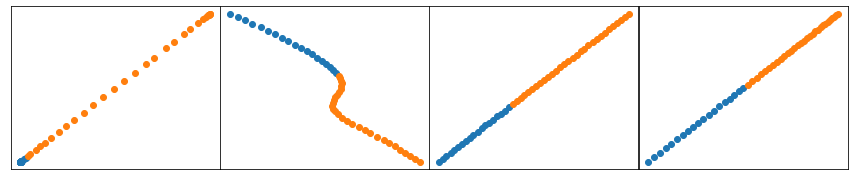

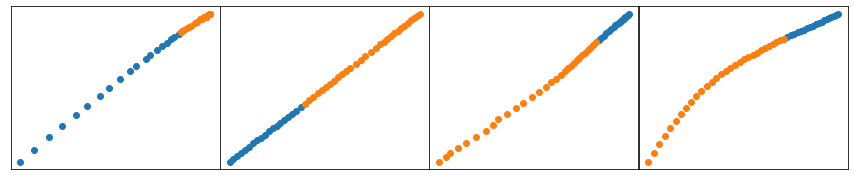

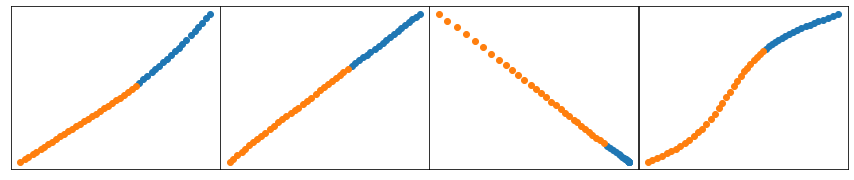

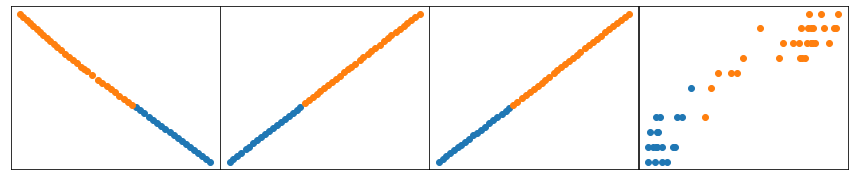

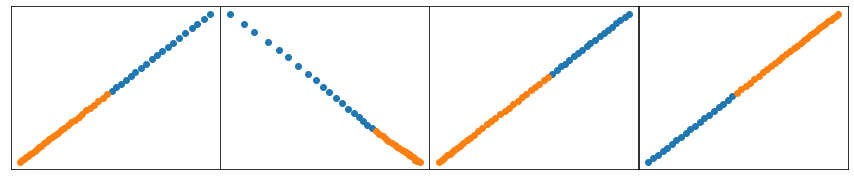

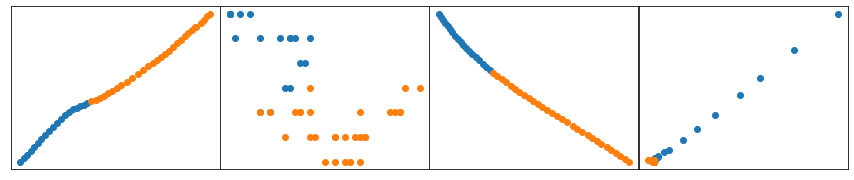

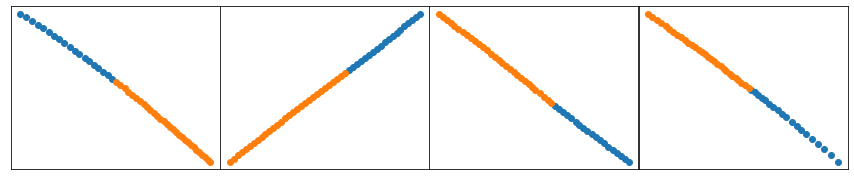

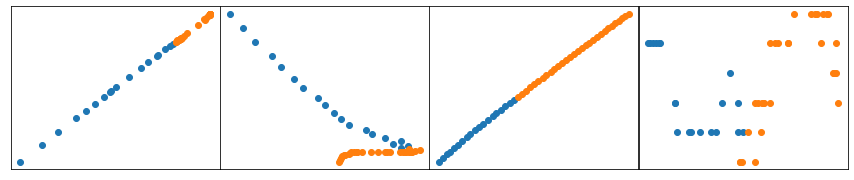

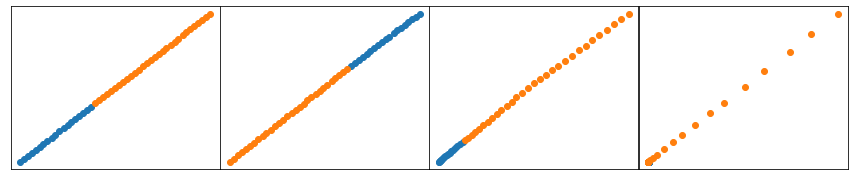

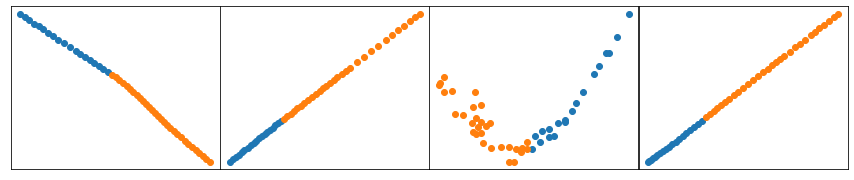

In [64]:
%matplotlib inline

agent_id = 0

def show_sample_batch(sample_batch, agent_id, path, num_batch):
    """visualize the trajectory for a batch of samples with a random agent"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1, batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])
    fn=os.path.join(path, "scatter-plot%i.pdf"%num_batch)
    fig.savefig(fn)
    
save_path='/home/apfriend/ucsd/CURRENT/cse151b/kaggle/latex/figures'
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    """TODO:
      Deep learning model
      training routine
    """
    show_sample_batch(sample_batch, agent_id, save_path, i_batch)
    if i_batch==9:
        break

In [62]:
%matplotlib widget

agent_id = 0

def show_sample_batch2(sample_batches, agent_id):
    """visualize the trajectory for a batch of samples with a random agent"""
    inp=[sample_batch[0] for sample_batch in sample_batches]
    out=[sample_batch[1] for sample_batch in sample_batches]
    
    batch_sz = inp[0].size(0)
    agent_sz = inp[0].size(1)
    
    num_batches=len(sample_batches)
    
    fig_size_x=15
    
    fig, axs = plt.subplots(
        num_batches, 
        batch_sz, 
        figsize=(fig_size_x, num_batches*fig_size_x), 
        facecolor='w', 
        edgecolor='k'
    )
    
    fig.subplots_adjust(hspace = .5, wspace=.001)
    
    print(axs.shape)
#     axs = axs.ravel()
    for j in range(len(axs)):
        for i in range(batch_sz):
            axs[i,j].xaxis.set_ticks([])
            axs[i,j].yaxis.set_ticks([])

            # first two feature dimensions are (x,y) positions
            axs[i,j].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
            axs[i,j].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])
            
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    """TODO:
      Deep learning model
      training routine
    """
    show_sample_batch2(sample_batch, agent_id)
    if i_batch==9:
        break

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(2, 60)


TypeError: list indices must be integers or slices, not tuple

In [ ]:
train_src=r'data/new_train/new_train'
test_src=r'data/new_val_in/new_val_in'
fn=r'0.pkl'
device='cuda'

data0=pd.read_pickle(os.path.join(src,fn))
# df0=pd.DataFrame(data0)
data0

In [ ]:
data0.keys()

In [ ]:
data_keys=['lane',
           'lane_norm',
           'car_mask',
           'p_in',
           'v_in',
           'p_out',
           'v_out',
           'track_id']

data00=dict(zip(data_keys, [data0[key].shape for key in data_keys]))
#df=pd.DataFrame.from_records(data00)
data00

In [ ]:
data0['lane']

In [ ]:
lane_df=pd.DataFrame({
    'lane':data0['lane'],
    'lane_norm':data0['lane_norm']
})
lane_df

In [ ]:
pd.DataFrame(data0)

In [ ]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)
                
        return data
#BATCH LOADER THAT GIVES [4, 1, 19, 2] TENSOR
batch_sz = 4

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x seq_len x feature] """
    inp = [[scene['p_in'][np.where(scene['track_id'][:,0,0] == scene['agent_id'])[0][0]]] for scene in batch]
    out = [[scene['p_out'][np.where(scene['track_id'][:,0,0] == scene['agent_id'])[0][0]][0]] for scene in batch]
    inp = torch.FloatTensor(inp)
    out = torch.FloatTensor(out)
    return [inp, out]


def my_collate_test(batch):
    """ collate lists of samples into batches, create [ batch_sz x seq_len x feature] """
    inp = [[scene['p_in'][np.where(scene['track_id'][:,0,0] == scene['agent_id'])[0][0]]] for scene in batch]
    out = [[scene['p_in'][np.where(scene['track_id'][:,0,0] == scene['agent_id'])[0][0]]] for scene in batch]
    inp = torch.FloatTensor(inp)
    out = torch.FloatTensor(out)
    return [inp, out]

In [ ]:
#need differnt collate function for validation set since it has no `p_out` or `v_out`

# val_loader = DataLoader(
#     val_dataset,
#     batch_size=batch_sz, 
#     shuffle = False, 
#     collate_fn=my_collate, 
#     num_workers=0
# )

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_sz, 
    shuffle = False, 
    collate_fn=my_collate_test, 
    num_workers=0
)

# intialize a dataset
val_dataset = ArgoverseDataset(data_path=train_src)

test_dataset = ArgoverseDataset(data_path=test_src)

val_dataset, test_dataset, val_loader, test_loader